In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import scipy.interpolate

### Setting lat, long, and time slices

In [2]:
# Define the lat/lon/time slices
lon_slice = slice(187.5, 192.5)   # LON187.5:192.5
lat_slice = slice(-12.5, -17.5)   # LAT-17.5:-12.5
time_slice = slice("1958-01-01", "2024-12-31")

# Define the final 3×3 target grid explicitly for interpolation
target_lons = np.array([187.5, 190.0, 192.5])
target_lats = np.array([-12.5, -15.0, -17.5])

# Dictionary to store each variable's subset
climate_data = {}

### Checking difference between skt.mon.mean.nc and skt.sfc.mon.mean.nc

In [3]:
# Checking the values in skt.mon.mean.nc and skt.sfc.mon.mean.nc
ds_skt = xr.open_dataset("data/climate_variables/skt.mon.mean.nc")
skin_temp = ds_skt.sel(lon=lon_slice, lat=lat_slice)["skt"]

ds_skt_sfc = xr.open_dataset("data/climate_variables/skt.sfc.mon.mean.nc")
skin_temp_sfc = ds_skt_sfc.sel(lon=lon_slice, lat=lat_slice)["skt"]

all_equal = np.all(skin_temp_sfc.values == skin_temp.values)
if all_equal:
  print("Skin temperature values in skt.mon.mean.nc are the SAME as skt.mon.sfc.mean.nc")
else:
  print("Skin temperature values in skt.mon.mean.nc are NOT THE SAME as skt.mon.sfc.mean.nc")

Skin temperature values in skt.mon.mean.nc are the SAME as skt.mon.sfc.mean.nc


### Subsetting data and saving to dictionary

In [4]:
# Subsetting data for all 16 variables and storing in dictionary.
# Assumes data is in a directory named "data" in working directory.

# 1) Air temp difference 1000–500
ds_air = xr.open_dataset("data/climate_variables/air.mon.mean.nc").sel(time=time_slice)
air_1000 = ds_air.sel(level=1000, lon=lon_slice, lat=lat_slice)["air"]
air_500  = ds_air.sel(level=500,  lon=lon_slice, lat=lat_slice)["air"]
climate_data["air_temp_diff_1000_500"] = air_1000 - air_500

# 2) Air 2m
ds_air2m = xr.open_dataset("data/climate_variables/air.2m.mon.mean.nc").sel(time=time_slice)

ds_air2m_interp = ds_air2m.interp(
    lat=target_lats,
    lon=target_lons,
    method="linear"  # or "nearest", "cubic"
)
climate_data["air_2m"] = ds_air2m_interp["air"]
# or ["t2m"], depending on your file

# 3) Geopotential Height 1000
ds_hgt = xr.open_dataset("data/climate_variables/hgt.mon.mean.nc").sel(time=time_slice)
climate_data["hgt_1000"] = ds_hgt.sel(level=1000, lon=lon_slice, lat=lat_slice)["hgt"]

# 4) Geopotential Height 500
climate_data["hgt_500"] = ds_hgt.sel(level=500, lon=lon_slice, lat=lat_slice)["hgt"]

# 5) Omega 500
ds_omega = xr.open_dataset("data/climate_variables/omega.mon.mean.nc").sel(time=time_slice)
climate_data["omega_500"] = ds_omega.sel(level=500, lon=lon_slice, lat=lat_slice)["omega"]

# 6) Potential Temperature difference 1000–500
ds_pottmp = xr.open_dataset("data/climate_variables/pottmp.mon.mean.nc").sel(time=time_slice)
pottmp_1000 = ds_pottmp.sel(level=1000, lon=lon_slice, lat=lat_slice)["pottmp"]
pottmp_500  = ds_pottmp.sel(level=500,  lon=lon_slice, lat=lat_slice)["pottmp"]
climate_data["pottmp_diff_1000_500"] = pottmp_1000 - pottmp_500

# 7) Potential Temperature difference 1000–850
pottmp_850 = ds_pottmp.sel(level=850, lon=lon_slice, lat=lat_slice)["pottmp"]
climate_data["pottmp_diff_1000_850"] = pottmp_1000 - pottmp_850

# 8) Precipitable Water
ds_prw = xr.open_dataset("data/climate_variables/pr_wtr.eatm.2025.nc").sel(time=time_slice)
climate_data["pr_wtr"] = ds_prw.sel(lon=lon_slice, lat=lat_slice)["pr_wtr"]

# 9) Specific Humidity 700
ds_shum = xr.open_dataset("data/climate_variables/shum.mon.mean.nc").sel(time=time_slice)
shum_700 = ds_shum.sel(level=700, lon=lon_slice, lat=lat_slice)["shum"]
climate_data["shum_700"] = shum_700

# 10) Specific Humidity 925
shum_925 = ds_shum.sel(level=925, lon=lon_slice, lat=lat_slice)["shum"]
climate_data["shum_925"] = shum_925

# 11) Zonal Moisture Transport 700
ds_uwnd = xr.open_dataset("data/climate_variables/uwnd.mon.mean.nc").sel(time=time_slice)
uwind_700 = ds_uwnd.sel(level=700, lon=lon_slice, lat=lat_slice)["uwnd"]
climate_data["zon_moist_700"] = uwind_700*shum_700

# 12) Zonal Moisture Transport 925
uwind_925 = ds_uwnd.sel(level=925, lon=lon_slice, lat=lat_slice)["uwnd"]
climate_data["zon_moist_925"] = uwind_925*shum_925

# 13) Meridional Moisture Transport 700
ds_vwnd = xr.open_dataset("data/climate_variables/vwnd.mon.mean.nc").sel(time=time_slice)
vwind_700 = ds_vwnd.sel(level=700, lon=lon_slice, lat=lat_slice)["vwnd"]
climate_data["merid_moist_700"] = vwind_700*shum_700

# 14) Meridional Moisture Transport 925
vwind_925 = ds_vwnd.sel(level=925, lon=lon_slice, lat=lat_slice)["vwnd"]
climate_data["merid_moist_925"] = vwind_925*shum_925

# 15) Skin Temperature
ds_skt_interp = ds_skt.interp(
    lat=target_lats,
    lon=target_lons,
    method="linear"
)

# Extract the skt variable from the interpolated dataset
climate_data["skin_temp"] = ds_skt_interp["skt"]

# 16) Sea Level Pressure
ds_slp = xr.open_dataset("data/climate_variables/slp.mon.mean.nc").sel(time=time_slice)
climate_data["slp"] = ds_slp.sel(lon=lon_slice, lat=lat_slice)["slp"]

### Checking that all variables are on the same grid

In [5]:
mismatched = []

for varname, da in climate_data.items():
    # Check if this DataArray has 'lat' and 'lon' dimensions
    # (some variables might have different dimension names or no lat/lon at all)
    if 'lat' in da.coords and 'lon' in da.coords:
        lat_ok = np.array_equal(da.lat.values, target_lats)
        lon_ok = np.array_equal(da.lon.values, target_lons)
        if not (lat_ok and lon_ok):
            mismatched.append(varname)
    else:
        mismatched.append(varname)  # no lat/lon coords at all

# Print results
if len(mismatched) == 0:
    print("All variables have lat/lon arrays matching the target arrays.")
else:
    print("These variables do NOT match the target lat/lon arrays:")
    for var in mismatched:
        print(f" - {var}")

All variables have lat/lon arrays matching the target arrays.


### Checking keys and the two variables we needed to interpolate

In [6]:
climate_data.keys()

dict_keys(['air_temp_diff_1000_500', 'air_2m', 'hgt_1000', 'hgt_500', 'omega_500', 'pottmp_diff_1000_500', 'pottmp_diff_1000_850', 'pr_wtr', 'shum_700', 'shum_925', 'zon_moist_700', 'zon_moist_925', 'merid_moist_700', 'merid_moist_925', 'skin_temp', 'slp'])

In [7]:
climate_data

{'air_temp_diff_1000_500': <xarray.DataArray 'air' (time: 804, lat: 3, lon: 3)> Size: 29kB
 array([[[31.299995, 31.269997, 31.04    ],
         [30.539993, 30.519997, 30.309998],
         [29.61    , 29.559998, 29.46    ]],
 
        [[31.879997, 31.94999 , 31.729996],
         [31.269997, 31.300003, 31.139992],
         [30.499992, 30.350006, 30.299995]],
 
        [[31.110008, 31.100006, 31.050003],
         [30.299995, 30.270004, 30.340004],
         [29.69999 , 29.64    , 29.789993]],
 
        ...,
 
        [[31.540314, 31.379026, 31.221775],
         [31.376606, 31.214504, 31.020954],
         [31.131443, 31.02338 , 30.94112 ]],
 
        [[31.85166 , 31.869162, 31.75999 ],
         [31.660822, 31.595827, 31.430824],
         [31.13082 , 31.07583 , 30.98999 ]],
 
        [[32.049187, 31.904022, 31.630644],
         [32.341125, 32.179024, 31.859669],
         [32.026604, 32.026604, 31.934666]]],
       shape=(804, 3, 3), dtype=float32)
 Coordinates:
   * lat      (lat) float32 12

In [8]:
climate_data

{'air_temp_diff_1000_500': <xarray.DataArray 'air' (time: 804, lat: 3, lon: 3)> Size: 29kB
 array([[[31.299995, 31.269997, 31.04    ],
         [30.539993, 30.519997, 30.309998],
         [29.61    , 29.559998, 29.46    ]],
 
        [[31.879997, 31.94999 , 31.729996],
         [31.269997, 31.300003, 31.139992],
         [30.499992, 30.350006, 30.299995]],
 
        [[31.110008, 31.100006, 31.050003],
         [30.299995, 30.270004, 30.340004],
         [29.69999 , 29.64    , 29.789993]],
 
        ...,
 
        [[31.540314, 31.379026, 31.221775],
         [31.376606, 31.214504, 31.020954],
         [31.131443, 31.02338 , 30.94112 ]],
 
        [[31.85166 , 31.869162, 31.75999 ],
         [31.660822, 31.595827, 31.430824],
         [31.13082 , 31.07583 , 30.98999 ]],
 
        [[32.049187, 31.904022, 31.630644],
         [32.341125, 32.179024, 31.859669],
         [32.026604, 32.026604, 31.934666]]],
       shape=(804, 3, 3), dtype=float32)
 Coordinates:
   * lat      (lat) float32 12

### Quick Visualization to check 2m air temp and skin temp

Units for air temp (2m): degK
Units for skin temp: degC


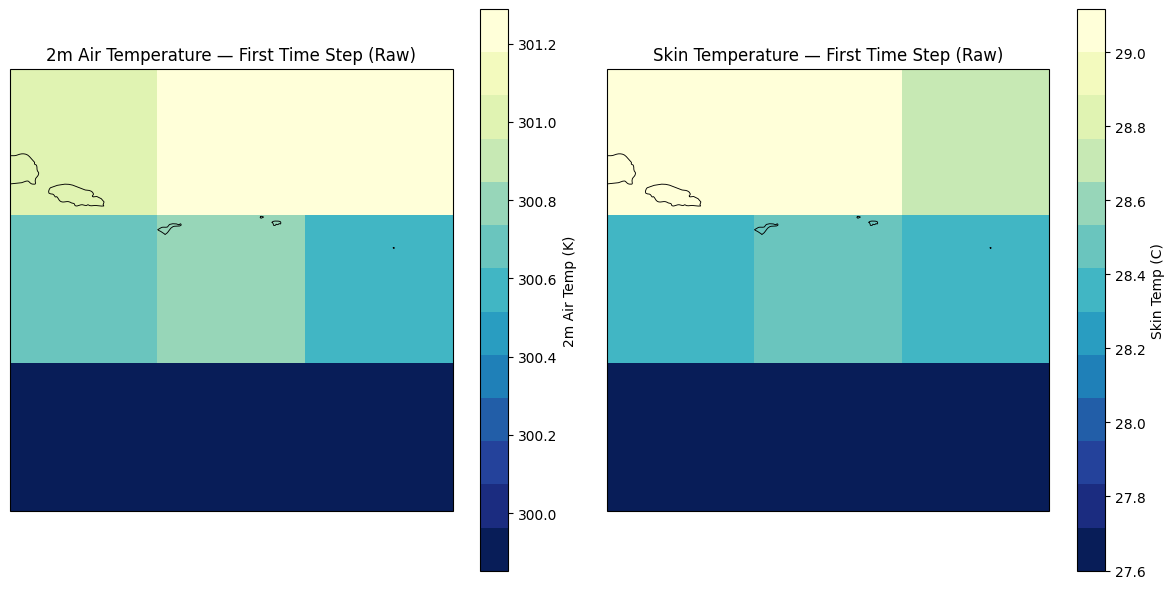

In [9]:
# Check units
print(f"Units for air temp (2m): {ds_air2m['air'].units}")
print(f"Units for skin temp: {ds_skt['skt'].units}")

# Extract the first time step for both variables (raw data)
air_2m_first = climate_data['air_2m'].isel(time=0)
skin_temp_first = climate_data['skin_temp'].isel(time=0)

# Squeeze any extra dimensions (if necessary) to obtain 2D arrays
data_2d_air = np.squeeze(air_2m_first.values)
data_2d_skin = np.squeeze(skin_temp_first.values)

# Define the desired target extent explicitly, subtracting 360 from longitudes
extent_target = [187.5-360, 192.5-360, -17.5, -12.5]

# Create a figure with two subplots side by side using PlateCarree projection
fig, (ax1, ax2) = plt.subplots(
    ncols=2, 
    figsize=(12, 6), 
    subplot_kw={'projection': ccrs.PlateCarree()}
)

# Plot 1: 2m Air Temperature using imshow
cmap_air = plt.get_cmap('YlGnBu_r', 13)
im1 = ax1.imshow(data_2d_air,
                 cmap=cmap_air,
                 transform=ccrs.PlateCarree(),
                 extent=extent_target)
ax1.coastlines(resolution='10m', linewidth=0.65)
ax1.set_title('2m Air Temperature — First Time Step (Raw)')
fig.colorbar(im1, ax=ax1, orientation='vertical', label='2m Air Temp (K)')

# Plot 2: Skin Temperature using imshow
cmap_skin = plt.get_cmap('YlGnBu_r', 13)
im2 = ax2.imshow(data_2d_skin,
                 cmap=cmap_skin,
                 transform=ccrs.PlateCarree(),
                 extent=extent_target)
ax2.coastlines(resolution='10m', linewidth=0.65)
ax2.set_title('Skin Temperature — First Time Step (Raw)')
fig.colorbar(im2, ax=ax2, orientation='vertical', label='Skin Temp (C)')

plt.tight_layout()
plt.show()

In [10]:
air_2m_first.values

array([[301.01597369, 301.28823967, 301.23585459],
       [300.65140801, 300.75550909, 300.58458137],
       [299.93089526, 299.95427449, 299.85243238]])

### Converting for export

In [21]:
# Create new Dataset with each variables as a data variable
final_ds = xr.Dataset()

for varname, da in climate_data.items():
    final_ds[varname] = da

final_ds.to_netcdf("AS_climate_var_ds.nc")

In [12]:
# Convert the dataset into a DataArray with a new 'variable' dimension:
final_da = final_ds.to_array(dim="variable")

# Transpose to get the dimension order to be (time, lat, lon, variable),
final_da = final_da.transpose("time", "lat", "lon", "variable")

In [13]:
final_da

<xarray.DataArray (time: 804, lat: 3, lon: 3, variable: 16)> Size: 926kB
array([[[[ 3.12999954e+01,  3.01015974e+02,  7.12903214e+01, ...,
          -7.10873652e+00,  2.92896641e+01,  1.00789716e+03],
         [ 3.12699966e+01,  3.01288240e+02,  7.21290359e+01, ...,
          -4.39332128e-01,  2.97194139e+01,  1.00810913e+03],
         [ 3.10400009e+01,  3.01235855e+02,  7.24516144e+01, ...,
           5.09831667e+00,  2.97109049e+01,  1.00802228e+03]],

        [[ 3.05399933e+01,  3.00651408e+02,  7.58387070e+01, ...,
           4.73519659e+00,  2.88644700e+01,  1.00854767e+03],
         [ 3.05199966e+01,  3.00755509e+02,  7.56451645e+01, ...,
           9.52134418e+00,  2.91218379e+01,  1.00861578e+03],
         [ 3.03099976e+01,  3.00584581e+02,  7.50322571e+01, ...,
           1.36353064e+01,  2.89419790e+01,  1.00840619e+03]],

        [[ 2.96100006e+01,  2.99930895e+02,  8.45483856e+01, ...,
           1.56407909e+01,  2.79862052e+01,  1.00951740e+03],
         [ 2.95599976e+01,  2.99954274e+02,  8.35483856e+01, ...,
           1.91757164e+01,  2.80175711e+01,  1.00930811e+03],
         [ 2.94599991e+01,  2.99852432e+02,  8.18064499e+01, ...,
           2.16918449e+01,  2.79488249e+01,  1.00914777e+03]]],
...
          -2.71202717e+01,  2.91433188e+01,  1.00884760e+03],
         [ 3.19040222e+01,  3.01489743e+02,  8.23145142e+01, ...,
          -2.60565586e+01,  2.93433267e+01,  1.00913458e+03],
         [ 3.16306438e+01,  3.01309867e+02,  8.45806427e+01, ...,
          -2.62856255e+01,  2.91689923e+01,  1.00923462e+03]],

        [[ 3.23411255e+01,  3.01271934e+02,  8.11935501e+01, ...,
          -2.10501385e+01,  2.87217293e+01,  1.00942584e+03],
         [ 3.21790237e+01,  3.01337731e+02,  8.41048355e+01, ...,
          -1.44001284e+01,  2.89192810e+01,  1.00966852e+03],
         [ 3.18596687e+01,  3.01058707e+02,  8.63145142e+01, ...,
          -1.47123032e+01,  2.87009975e+01,  1.00965002e+03]],

        [[ 3.20266037e+01,  3.00716252e+02,  8.51532288e+01, ...,
          -1.71265068e+01,  2.81021361e+01,  1.00969751e+03],
         [ 3.20266037e+01,  3.00587893e+02,  8.70725784e+01, ...,
          -7.32536507e+00,  2.78906608e+01,  1.00981219e+03],
         [ 3.19346657e+01,  3.00389156e+02,  8.84354858e+01, ...,
          -8.67440510e+00,  2.77257533e+01,  1.01001123e+03]]]],
      shape=(804, 3, 3, 16))
Coordinates:
  * lat       (lat) float32 12B -12.5 -15.0 -17.5
  * lon       (lon) float32 12B 187.5 190.0 192.5
  * time      (time) datetime64[ns] 6kB 1958-01-01 1958-02-01 ... 2024-12-01
    level     float32 4B 1e+03
  * variable  (variable) object 128B 'air_temp_diff_1000_500' 'air_2m' ... 'slp'

In [14]:
# final_da.to_netcdf("AS_climate_var.nc")

### Opening saved file for final check

In [22]:
ds = xr.open_dataset("data/extracted_climate_var/AS_climate_var_ds.nc")
ds

<xarray.Dataset> Size: 527kB
Dimensions:                 (lat: 3, lon: 3, time: 804)
Coordinates:
  * lat                     (lat) float32 12B -12.5 -15.0 -17.5
  * lon                     (lon) float32 12B 187.5 190.0 192.5
  * time                    (time) datetime64[ns] 6kB 1958-01-01 ... 2024-12-01
    level                   float32 4B ...
Data variables: (12/16)
    air_temp_diff_1000_500  (time, lat, lon) float32 29kB ...
    air_2m                  (time, lat, lon) float64 58kB ...
    hgt_1000                (time, lat, lon) float32 29kB ...
    hgt_500                 (time, lat, lon) float32 29kB ...
    omega_500               (time, lat, lon) float32 29kB ...
    pottmp_diff_1000_500    (time, lat, lon) float32 29kB ...
    ...                      ...
    zon_moist_700           (time, lat, lon) float32 29kB ...
    zon_moist_925           (time, lat, lon) float32 29kB ...
    merid_moist_700         (time, lat, lon) float32 29kB ...
    merid_moist_925         (time, lat, lon) float32 29kB ...
    skin_temp               (time, lat, lon) float64 58kB ...
    slp                     (time, lat, lon) float32 29kB ...

In [20]:
final_ds["slp"]

<xarray.DataArray 'slp' (time: 804, lat: 3, lon: 3)> Size: 29kB
array([[[1007.89716, 1008.10913, 1008.0223 ],
        [1008.54767, 1008.6158 , 1008.4062 ],
        [1009.5174 , 1009.3081 , 1009.14777]],

       [[1008.6436 , 1008.78937, 1008.804  ],
        [1009.2201 , 1009.295  , 1009.17285],
        [1009.89044, 1009.8578 , 1009.771  ]],

       ...,

       [[1010.2526 , 1010.4826 , 1010.58   ],
        [1011.3309 , 1011.3984 , 1011.35675],
        [1012.4691 , 1012.34174, 1012.495  ]],

       [[1008.8476 , 1009.1346 , 1009.2346 ],
        [1009.42584, 1009.6685 , 1009.65   ],
        [1009.6975 , 1009.8122 , 1010.0112 ]]],
      shape=(804, 3, 3), dtype=float32)
Coordinates:
  * lat      (lat) float32 12B -12.5 -15.0 -17.5
  * lon      (lon) float32 12B 187.5 190.0 192.5
  * time     (time) datetime64[ns] 6kB 1958-01-01 1958-02-01 ... 2024-12-01
    level    float32 4B 1e+03
Attributes:
    long_name:     Sea Level Pressure
    valid_range:   [ 870. 1150.]
    units:         millibars
    precision:     1
    var_desc:      Sea Level Pressure
    level_desc:    Sea Level
    statistic:     Mean
    parent_stat:   Other
    dataset:       NCEP Reanalysis Derived Products
    actual_range:  [ 955.56085 1082.5582 ]

In [19]:
for var in ds.data_vars:
    print(var, ds[var].dims, ds[var].dtype)

__xarray_dataarray_variable__ ('time', 'lat', 'lon', 'variable') float64
